# Samlping and Computing Average with a Gene Expression Mechanism

## Reference

[1] Vlachos, D. "CHEG841 Class Notes" Department of Chemical Engineering, University of Delaware 

[2] [ Alexopoulos, K.; Wang, Y.; Vlachos, D. G. First-Principles Kinetic and Spectroscopic Insights into Single-Atom Catalysis. ACS Catal. 2019, 3 (100), 5002–5010.](https://pubs.acs.org/doi/10.1021/acscatal.9b00179)

[3] [ Temel, B.; Meskine, H.; Reuter, K.; Scheffler, M.; Metiu, H. Does Phenomenological Kinetics Provide an Adequate Description of Heterogeneous Catalytic Reactions? J. Chem. Phys. 2007, 126 (20), 204711.](https://aip.scitation.org/doi/abs/10.1063/1.2741556)

Date: 06-14-2019

# Table of contents


- [1. Introduction](#introduction)

    
- [2. General approaches](#generalapproaches)
    
    
- [3. Case Study (a Gene Expression mechanism)](#case)

    - [3.1 Gillespie's Algorithm](#gillespie)

    - [3.2 Tau-leaping](#tauleaping)

    - [3.3 Mean-Field ODEs](#ode)


- [4. Sampling and Storing Outputs](#data)

    - [4.1. Output Every Event](#event)
    
    - [4.2. Sample on Event](#events)
    
    - [4.3. Sample on Time](#time)

    
- [5. Computing Average](#mean)

    - [5.1. Compute Average Populations](#mean_pop)
    
    - [5.2. Compute Average Rates](#rates)
    
      &nbsp;&nbsp;&nbsp;&nbsp;  [5.2.1 The Time Average Method](#rates_time)
      
      &nbsp;&nbsp;&nbsp;&nbsp;  [5.2.2 Events-based Method](#rates_event)
    
    
- [6. kMC vs Mean-field](#vs)



# 1. Introduction <a name="introduction"></a>

Goal: to track the number of molecules of each type as a function of reaction time and compute the average of kMC trajectories 

Assumption: a well-mixed system, where moleculses of each type are spread uniformaly throughout the spatial domain
    
# 2. General approaches<a name="generalapproaches"></a>   

- __Kinetic Monte Carlo (kMC)__ , solving chemical matser equations through 
    - Gillespie's algorithm
    - Tau-leaping methods
- Reaction Rate equations through the __mean-field ODEs__

# 3. Case Study (a Gene Expression mechanism)<a name="case"></a>   

The system involves 2 species (the DNA population is not included):
- mRNA, $r$
- Protein, $p$

![flowchart](input_graphics/gene_expression.PNG)
 
 
The mechanism can be written as
1. Transcription of $r$: DNA $\xrightarrow{\text{kr}} r$
2. Transcription of $p$: $r \xrightarrow{\text{kp}} r + p$
3. Decay of $r$: $r \xrightarrow{\text{$\gamma_{r}$}}$
4. Decay of $p$: $p \xrightarrow{\text{$\gamma_{p}$}}$

Where c1, c2, c3 and c4 are rate constants.


The concentrations of mRNA (r) and protein (p) are given by the following ODEs:

$\frac{dr}{dt} = k_{r} - \gamma_{r} r $

$\frac{dp}{dt} = k_{p}r - \gamma_{p} p $

The steady state solution is,

$r_{ss} = k_{r}/\gamma_{r}$

$p_{ss} = k_{p}k_{r}/\gamma_{p}\gamma_{r} $

In [1]:
# Imports necessary libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.integrate import odeint, ode

# Set random seed
np.random.seed(0)

## 3.1 Gillespie's Algorithm <a name="gillespie"></a>  

In [2]:
# Define a Gillespie's algorithm function starting from t = 0

def gill_alg(pop, tfinal, c):
    
    t = 0
    
    # Stoichiometric matrix
    V = np.array([(1, 0,-1,0), (0,1,0,-1)])
    
    # Create an array to store time, # of mRNA-r and # of protein-p, event index j
    data = np.array([(0, pop[0], pop[1], float('NaN'))]) # at t = 0, no past event is fired

    while t < tfinal:
        a=np.zeros((4,1)) # Probabilities of reactions
        a[0] = c[0];
        a[1] = c[1]*pop[0];
        a[2] = c[2]*pop[0];
        a[3] = c[3]*pop[1];
        asum = np.sum(a)

        # Uses random numbers to determine time step and reaction
        j = np.min(np.nonzero(np.random.rand()<np.cumsum(a/asum)))
        tau = np.log(1/np.random.rand())/asum
        
        pop = pop + V[:,j] # Updates populations
        t = t + tau

        data = np.append(data, [(t, pop[0], pop[1], j)], axis = 0)
        
    return data

## Scenario 1

$ k_{r} = 0.01 $

$ k_{p} = 1 $ 

$ \gamma_{r} = 0.1 $

$ \gamma_{p} = 0.002 $ 

Hence, $r_{ss} = 0.1$ and $p_{ss} = 50$

In [3]:
# Using Gillespie's Algorithm to model a system with nonlinear dynamic behavior, 
# including oscillations and bistability in cubic autocatalysis

Y = np.zeros(2) # Start with populations of 0

# All first order reaction
# Continum rate constants k = molecular rate constants c
c=np.zeros(4)
c[0] = 0.01 #kr
c[1] = 1 #kp
c[2] = 0.1 #gamma r
c[3] = 0.002 #gamma p  

tfinal = 28800

start = time.time()
print('Starting kMC simulations...')

# Run the simulation
val_ga_1 = gill_alg(Y, tfinal, c)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 0.4737 s


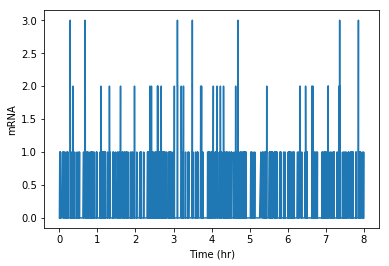

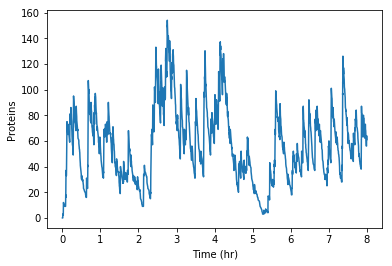

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ga_1[:,0]/3600,val_ga_1[:,1])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('mRNA');

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ga_1[:,0]/3600,val_ga_1[:,2])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Proteins');

## Scenario 2

$ k_{r} = 0.1 $

$ k_{p} = 0.1 $ 

$ \gamma_{r} = 0.1 $

$ \gamma_{p} = 0.002 $ 

Hence, $r_{ss} = 1$ and $p_{ss} = 50$

In [5]:
Y = np.zeros(2)

c=np.zeros(4)
c[0] = 0.1 #kr
c[1] = 0.1 #kp
c[2] = 0.1 #yr
c[3] = 0.002 #yp  

tfinal = 28800

start = time.time()
print('Starting kMC simulations...')

# Run the simulation
val_ga_2 = gill_alg(Y, tfinal, c)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 0.7541 s


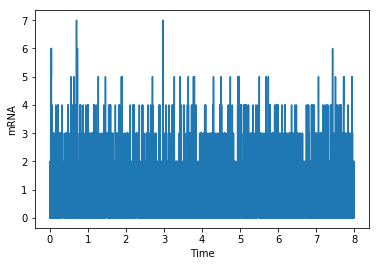

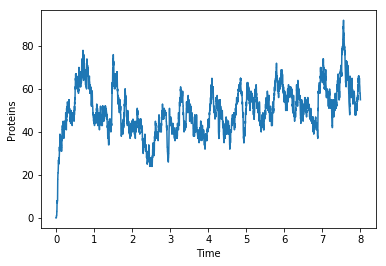

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ga_2[:,0]/3600,val_ga_2[:,1])
ax.set_xlabel('Time')
ax.set_ylabel('mRNA');

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ga_2[:,0]/3600,val_ga_2[:,2])
ax.set_xlabel('Time')
ax.set_ylabel('Proteins');

## 3.2 Tau-leaping<a name="tau"></a>  

In [7]:
# Define a tau-leaping function starting from t = 0

def tau_leap(pop, c, tfinal, tau):
    
    # Create an array to store time, # of mRNA-r and # of protein-p
    data = np.array([(0, pop[0], pop[1])])
    
    V = np.array([(1, 0,-1,0), (0,1,0,-1)]) # Matrix of reaction vectors    
    
    # Updates concentrations over timeframes until tfinal is reached
    for k in range(round(tfinal/tau)):
        a=np.zeros((4,1)) # Probabilities of reactions
        a[0] = c[0];
        a[1] = c[1]*pop[0];
        a[2] = c[2]*pop[0];
        a[3] = c[3]*pop[1];

        # Uses normally distributed random numbers to determine extents if reaction
        d=np.zeros((4,1))
        d[0] = tau*a[0] + np.sqrt(abs(tau*a[0]))*np.random.randn()
        d[1] = tau*a[1] + np.sqrt(abs(tau*a[1]))*np.random.randn()
        d[2] = tau*a[2] + np.sqrt(abs(tau*a[2]))*np.random.randn()
        d[3] = tau*a[3] + np.sqrt(abs(tau*a[3]))*np.random.randn()

        # Updates populations
        pop = pop + d[0]*V[:,0] + d[1]*V[:,1] + d[2]*V[:,2] + d[3]*V[:,3]
        np.around(pop,0)
        if pop[0] < 0:
            pop[0] = 0
        if pop[1] < 0:
            pop[1] = 0
        data = np.append(data, [(k*tau, pop[0], pop[1])], axis = 0)
 
    return data

## Scenario 1

$ k_{r} = 0.01 $

$ k_{p} = 1 $ 

$ \gamma_{r} = 0.1 $

$ \gamma_{p} = 0.002 $ 

The steady state populations are, $r_{ss} = 0.1$ and $p_{ss} = 50$

In [8]:
V = np.array([(1, 0,-1,0), (0,1,0,-1)]) # Matrix of reaction vectors

Y = np.zeros(2) #Populations of molecules

c=np.zeros(4) #Reaction coefficients
c[0] = 0.01 #kr
c[1] = 1 #kp
c[2] = 0.1 #yr
c[3] = 0.002 #yp

tfinal = 28800 #time related variables
# set "small enough" tau
tau = tfinal/1000 #s

start = time.time()
print('Starting kMC simulations...')

# Run the simulation
val_tl_1 = tau_leap(Y, c, tfinal, tau)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 0.0745 s


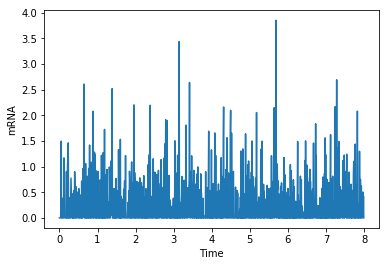

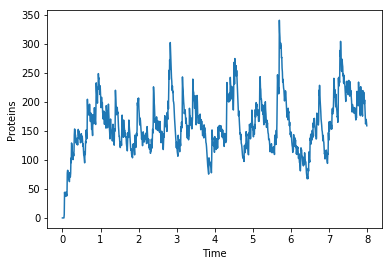

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_tl_1[:,0]/3600,val_tl_1[:,1])
ax.set_xlabel('Time')
ax.set_ylabel('mRNA');

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_tl_1[:,0]/3600,val_tl_1[:,2])
ax.set_xlabel('Time')
ax.set_ylabel('Proteins');

## Scenario 2

$ k_{r} = 0.1 $

$ k_{p} = 0.1 $ 

$ \gamma_{r} = 0.1 $

$ \gamma_{p} = 0.002 $ 

The steady state populations are, $r_{ss} = 1$ and $p_{ss} = 50$

In [10]:
# With different reaction coefficients

Y = np.zeros(2) #Populations of molecules

c=np.zeros(4) #Reaction coefficients
c[0] = 0.1 #kr
c[1] = 0.1 #kp
c[2] = 0.1 #yr
c[3] = 0.002 #yp

tfinal = 28800 #time related variables
tau = tfinal/1000

start = time.time()
print('Starting kMC simulations...')

# Run the simulation
val_tl_2 = tau_leap(Y, c, tfinal, tau)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 0.1790 s


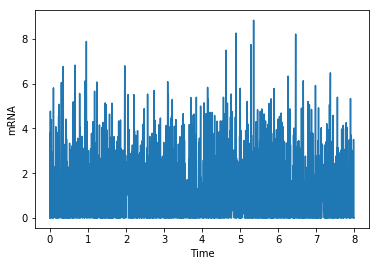

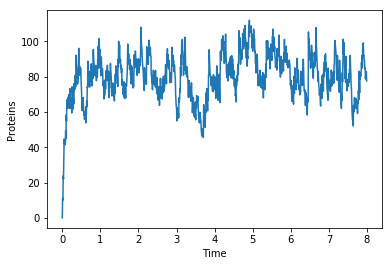

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_tl_2[:,0]/3600,val_tl_2[:,1])
ax.set_xlabel('Time')
ax.set_ylabel('mRNA');

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_tl_2[:,0]/3600,val_tl_2[:,2])
ax.set_xlabel('Time')
ax.set_ylabel('Proteins');

## 3.3 Mean-Field ODEs<a name="ode"></a>  

## Scenario 1<a name="ode_s1"></a>  

$ k_{r} = 0.01 $

$ k_{p} = 1 $ 

$ \gamma_{r} = 0.1 $

$ \gamma_{p} = 0.002 $ 

The steady state populations are, $r_{ss} = 0.1$ and $p_{ss} = 50$

The ode solutions converges to the steady state solutions

In [12]:
tspan = np.array([0,28800])

y0 = np.zeros(2) #Initial concentrations

kr = 0.01 # Reaction coefficients
kp = 1
yr = 0.1
yp = 0.002

r_ss_1 = kr/yr # analytical steady state solution
p_ss_1 = kr/yr * kp/yp

sol = []

In [13]:
def kin(t,y): # ode of the reaction for each molecule
    yprime = np.zeros(2);
    yprime[0] = kr - yr*y[0]
    yprime[1] = kp*y[0] - yp*y[1]
    return yprime

In [14]:
# Feeds information to vode, an ode15s equivalent
solver2=ode(kin).set_integrator('vode',rtol=1e-5,method='bdf') 
solver2.set_initial_value(y0,tspan[0])
t, yout= [tspan[0]],[y0]

# the time step to output the results 
dt = 0.01 

start = time.time()
while solver2.successful() and solver2.t < tspan[1]:
    solver2.integrate(solver2.t+dt, step=True)
    t.append(solver2.t)
    yout.append(solver2.y)

end = time.time()
print('Solving odes takes {0:.4f} s'.format(end-start))

t_o1 = np.array(t)
yout_o1 = np.array(yout)

Solving odes takes 0.1198 s


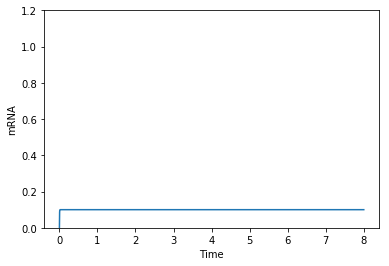

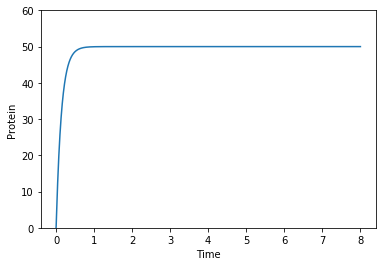

In [15]:
fig = plt.figure() # Produces plots of the data
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('mRNA')
ax.set_ylim(0,1.2)
ax.plot(t_o1/3600,yout_o1[:,0]);

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('Protein')
ax.set_ylim(0,60)
ax.plot(t_o1/3600,yout_o1[:,1]);

## Scenario 2

$ k_{r} = 0.1 $

$ k_{p} = 0.1 $ 

$ \gamma_{r} = 0.1 $

$ \gamma_{p} = 0.002 $ 

The steady state populations are, $r_{ss} = 1$ and $p_{ss} = 50$

The ode solutions converges to the steady state solutions

In [16]:
tspan = np.array([0,28800])

y0 = np.zeros(2) #Initial concentrations

kr = 0.1 # Reaction coefficients
kp = 0.1
yr = 0.1
yp = 0.002

r_ss_2= kr/yr # analytical steady state solution
p_ss_2 = kr/yr * kp/yp

In [17]:
# Feeds information to vode, an ode15s equivalent
solver2=ode(kin).set_integrator('vode',rtol=1e-5,method='bdf') 
solver2.set_initial_value(y0,tspan[0])
t, yout= [tspan[0]],[y0]

# the time step to output the results 
dt = 0.01 

start = time.time()

while solver2.successful() and solver2.t < tspan[1]:
    solver2.integrate(solver2.t+dt, step=True)
    t.append(solver2.t)
    yout.append(solver2.y)
    
end = time.time()
print('Solving odes takes {0:.4f} s'.format(end-start))

t_o2 = np.array(t)
yout_o2 = np.array(yout)

Solving odes takes 0.1114 s


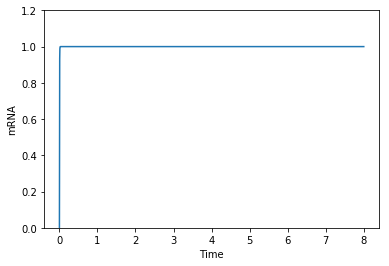

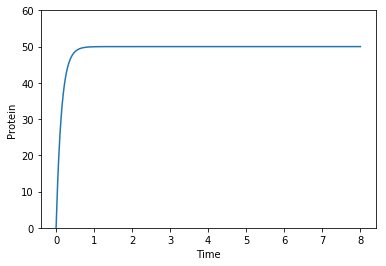

In [18]:
fig = plt.figure() # Produces plots of the data
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('mRNA')
ax.set_ylim(0,1.2)
ax.plot(t_o2/3600,yout_o2[:,0]);

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('Protein');
ax.set_ylim(0,60)
ax.plot(t_o2/3600,yout_o2[:,1]);

# 4. Sampling and Storing Outputs <a name="sampling"></a>  

If we have simluations that take a long time, it is better to storage the output data and do the analysis later. 

We can convert the numpy arrays containing the time and species population at each kMC event into a format that's easier to read and post-process using __pandas data frames__ and then store them to __csv__ files.

The following examples are demonstrated by scenario 2 from Gillespie's algorithm

## 4.1 Output Every Event <a name="event"></a>  

In [19]:
# Add a column for the number of events
n_events = np.arange(0, len(val_ga_2))

# convert np array to a pd dataframe
raw_df = {'Nevents':n_events,
         'Time (s)': val_ga_2[:,0],
         'Reaction Index': val_ga_2[:,3],
         'mRNA Population': val_ga_2[:,1],
         'Protein Population': val_ga_2[:, 2]}

ga_df = pd.DataFrame(raw_df)


# Preview the firs 20 evnets in the dataframe
ga_df.head(n = 20)

,Nevents,Time (s),Reaction Index,mRNA Population,Protein Population
0,0,0.000000,NaN,0.0,0.0
1,1,0.403702,0.0,1.0,0.0
2,2,2.982009,2.0,0.0,0.0
3,3,13.881801,0.0,1.0,0.0
4,4,22.155466,0.0,2.0,0.0
5,5,29.890637,2.0,1.0,0.0
6,6,31.172879,1.0,1.0,1.0
7,7,32.319788,2.0,0.0,1.0
8,8,62.275835,0.0,1.0,1.0
9,9,63.165673,0.0,2.0,1.0


In [20]:
# Save the dataframe to a csv file for post-processing
ga_df.to_csv('Gene_Expression_All_Events.csv')

## 4.2 Sample on Event<a name="events"></a>  

To save memory, sample at every k events (k is an integer) and store the output into a csv file

In [21]:
# sample every k events
k_sample = 500

# Creates table display for sample data points by events
sample_events = np.array(range(0,len(val_ga_2)-1, k_sample)) #Initial, final, on k events
sample_events = np.append(sample_events,len(val_ga_2)-1) # Include the final event
time_df = []
index_df = []
m_df = []
p_df = []
for i in sample_events: # add data to respective column array
    time_df.append(val_ga_2[i][0]) # s
    index_df.append(val_ga_2[i][3])
    m_df.append(val_ga_2[i][1])
    p_df.append(val_ga_2[i][2])

time_df = np.array(time_df)
m_df = np.array(m_df)
p_df = np.array(p_df)

# Place data into a dataframe
raw_df = {'Nevents':sample_events,
         'Time (s)': time_df,
         'Reaction Index': index_df,
         'mRNA Population': m_df,
         'Protein Population': p_df}
sample_events_df = pd.DataFrame(raw_df)

# Preview the first 20 evnets in the dataframe
sample_events_df.head(n = 20)

,Nevents,Time (s),Reaction Index,mRNA Population,Protein Population
0,0,0.000000,NaN,0.0,0.0
1,500,1393.460275,3.0,2.0,48.0
2,1000,2435.940540,1.0,3.0,73.0
3,1500,3641.788929,1.0,3.0,45.0
4,2000,4893.961595,2.0,0.0,38.0
5,2500,6016.557183,2.0,1.0,53.0
6,3000,7371.870449,3.0,1.0,43.0
7,3500,8719.039132,0.0,2.0,30.0
8,4000,10245.884913,0.0,2.0,50.0
9,4500,11682.222323,2.0,3.0,51.0


In [22]:
# Save the dataframe to a csv file for post-processing
sample_events_df.to_csv('output_files/Gene_Expression_Sample_Events.csv')

## 4.2 Sample on Time<a name="time"></a> 

We can also simple data points at linearly spaced time points.

In [23]:
# To store select data points at a time interval

t_gap = 1800 #s
t_lim = t_gap
n_events = [0]
for i in range(len(val_ga_2)-1): # Select data points to include
    if val_ga_2[i][0] >= t_lim:
        n_events.append(i)
        t_lim += t_gap
        
n_events = np.append(n_events,len(val_ga_2)-1) # include the final event
time_df = []
index_df = []
m_df = []
p_df = []

for i in n_events: # Add data to respective column array
    time_df.append(round(val_ga_2[i][0],2)) # s
    index_df.append(val_ga_2[i][3])
    m_df.append(val_ga_2[i][1])
    p_df.append(val_ga_2[i][2])

time_df = np.array(time_df)
m_df = np.array(m_df)
p_df = np.array(p_df)

# Place data into a dataframe
raw_df = {'Steps':n_events,
         'Time (s)': time_df,
         'Reaction Index': index_df,
         'mRNA Population': m_df,
         'Protein Population': p_df}
sample_time_df = pd.DataFrame(raw_df)

# Preview the first 20 evnets in the dataframe
sample_time_df.head(n = 20)

,Steps,Time (s),Reaction Index,mRNA Population,Protein Population
0,0,0.00,NaN,0.0,0.0
1,677,1801.11,0.0,2.0,57.0
2,1480,3604.23,2.0,1.0,47.0
3,2228,5400.20,2.0,0.0,74.0
4,2927,7204.11,1.0,1.0,44.0
5,3589,9001.69,3.0,0.0,25.0
6,4220,10821.95,0.0,1.0,43.0
7,4826,12604.28,3.0,0.0,50.0
8,5501,14401.49,2.0,0.0,45.0
9,6234,16201.44,0.0,4.0,42.0


In [24]:
# Save the dataframe to a csv file for post-processing
sample_time_df.to_csv('output_files/Gene_Expression_Sample_Time.csv')

# 5. Computing  Averages <a name="mean"></a>  

The plots make it appear that the kMC methods result in higher populations of mRNA compared to the steady state rate solution given by the mean-field. This is due to a large amount of fluctuations in the population, and the difficulty in displaying populations in short time frames. The average properties in kMC simulations are meaningful quantities to compute to counter stochatic noise.

A property $Y(t)$ can be esitamted as arithmetic or time averages. Due to __ergodicity__, temporal and ensemble averages should gives the same results. For a long time T and many observations N, the time average is approximated by:

$\frac{1}{T}\int_{0}^{T} Y(T) dt  \approx \frac{1}{T} \sum_{i=1}^{N} Y(t_{i}) \Delta t_{i} \approx \frac{1}{N} \sum_{i=1}^{N} Y_{i} $

where it assumes that interval (0, T) has been divided into N subintervals and each with the size of $t_{i}$. 

Only when the transition probabilities and the time steps do not change much, the second equality works well. Therefore, computing time averages is recommended instead of simple arithmetic means. 

In order to access whether steady state has been reached, the kMC simulations are partitioned in subintervals or windows of certain number of MC events. In many cases, two windows are introduced. The first contains the induction period and it should be long enough so that the initial transients have decayed. The second window which has a much larger size describes the steady state of equilibrium state. We focus our discussion of average properties mainly on the steady state in the second window and disgard __Nw__ MC events which are considered to be in the first window.

## 5.1 Compute Average Populations<a name="mean_pop"></a> 

Time average population sizes can be computed. For kth species, the time average between times $t$ and $t+\tau$ is

$\bar X_{k} = \frac{1}{\tau}\int_{t}^{t+\tau} X_{k}(i) dt  = \frac {\sum_{i=1}^{n} X_{k}(i) \Delta t(i)}{\tau}= \sum_{i=1}^{n} X_{k}(i) p(i) $ 


The last equality introduces the probability spent in state i, $p(i) = \Delta t(i)/\tau $

We can compare the time average values with the arithmetic average $ \frac{1}{N} \sum_{i=1}^{N} X_{k}(i) $

In [25]:
# A function to calculate the time average property 
# given a vector of time and corresponding quantities

def time_average(time_v, x_v):
    
    dt = np.diff(time_v) # calculate dt
    x = x_v[1:] # starting from the 2nd point
    
    x_mean_t = np.dot(dt, x)/np.sum(dt)
    
    return x_mean_t

In [26]:
# For gillespie's, scenario 2
# Disgard the first 1/4 of total events in the first window
val_ga_2_ss = val_ga_2[round(len(val_ga_2)/4):,:]

tv_ga = val_ga_2_ss[:,0]
mRNAv_ga = val_ga_2_ss[:,1]
prov_ga = val_ga_2_ss[:,2]

# the time section 
tau = tv_ga[-1] - tv_ga[0]

# time averages
mRNA_mean_t_ga = time_average(tv_ga, mRNAv_ga)
pro_mean_t_ga = time_average(tv_ga, prov_ga)

# airthmetic averages
mRNA_mean_a_ga = np.mean(mRNAv_ga)
pro_mean_a_ga = np.mean(prov_ga)

# For tau-leaping, scenario 2

# Disgard the first 1/4 of total events in the first window
val_tl_2_ss = val_tl_2[round(len(val_tl_2)/4):,:]

tv_tl = val_tl_2_ss[:,0]
mRNAv_tl = val_tl_2_ss[:,1]
prov_tl = val_tl_2_ss[:,2]

# time averages
mRNA_mean_t_tl = time_average(tv_tl, mRNAv_tl)
pro_mean_t_tl = time_average(tv_tl, prov_tl)

# arithmetic averages
mRNA_mean_a_tl = np.mean(mRNAv_tl)
pro_mean_a_tl = np.mean(prov_tl)

# Display the average values 
average_data = [['mRNA / GA', mRNA_mean_t_ga, mRNA_mean_a_ga, r_ss_2], 
                ['Protein / GA', pro_mean_t_ga, pro_mean_a_ga, p_ss_2], 
                ['mRNA / tau-leaping', mRNA_mean_t_tl, mRNA_mean_a_tl, r_ss_2],
                ['Protein / tau-leaping', pro_mean_t_tl, pro_mean_a_tl, p_ss_2]]

pd.DataFrame(average_data, columns=["Xi / method", "Time Average", 'Arithmetic Mean', 'Mean-field (ODE)'])

,Xi / method,Time Average,Arithmetic Mean,Mean-field (ODE)
0,mRNA / GA,1.124304,1.480591,1.0
1,Protein / GA,49.649494,50.771950,50.0
2,mRNA / tau-leaping,1.600032,1.601623,1.0
3,Protein / tau-leaping,81.308485,81.319134,50.0


## 5.2 Compute Average Rates <a name="rates"></a> 

### 5.2.1 The Time Average Method<a name="rates_time"></a> 

For kth microscopic process, the time average rate between times $t$ and $t+\tau$ is

$\bar r_{k} = \frac{1}{\tau}\int_{t}^{t+\tau} a_{k}(i) dt  = \frac {\sum_{i=1}^{n} a_{k}(i) \Delta t(i)}{\tau} $

Where $a_{k}(i)$ is the propensity of process k at time t.

### 5.2.2 Events-based Method<a name="rates_event"></a> 

The number of molecular events, $\xi_{k}$, of the kth process taking place during the time interval $\tau$ can be used to compute rates since the number of events occurred can be easily kept track of.

$\bar r_{k} = \frac{\xi_{k}}{\tau}$

The rate can be converted to moles per unit time or __turnover frequency (TOF)__ by dividing $N_{av} vol$ or $N_{s} N_{av} area$ , respectively. ($N_{s}$ is the total number of sites for surface processes).


Here, we compare the kMC rates with the average concentration-based rates from mean-field.

For example, reaction 2, transcription of $p$: $r \xrightarrow{\text{kp}} r + p$, is 1st order with respect to mRNA (r).

Its average rates between times $t$ and $t+\tau$ can be written as:

| Method        | $\bar r_{2} $ |
| ------------- |:-------------:| 
| Time Average  | $ \frac {\sum_{i=1}^{n} k_{p} X_{r}(i) \Delta t(i)}{\tau}  =  k_{p} \bar X_{r} $| 
| Events-base   | $ \frac{\xi_{2}}{\tau}$                                                          |
| Mean-field    | $ k_{p} [r]_{ss} $                                                               | 


In [27]:
# For gillespie's, scenario 2

# Time average rates 
rate_t_ga = kp * mRNA_mean_t_ga #molecule/

# Event-rates
# Count the number of events which has reaction index == 1 
# (python index, real index 2)
rate_event_ga = len(np.where(val_ga_2_ss[:,3] == 1)[0])/tau

# Mean-field rates
rate_ss = kp * r_ss_2


# Display the average values 
average_data = [['rate / GA', rate_t_ga, rate_event_ga, rate_ss]]

pd.DataFrame(average_data, columns=["Xi / method", "Time Average", 'Event-based', 'Mean-field (ODE)'])

,Xi / method,Time Average,Event-based,Mean-field (ODE)
0,rate / GA,0.11243,0.097973,0.1


## 5.3 kMC vs Mean-field <a name="vs"></a> 

As shown above, for __linear kinetics__, one can compute the kMC average quantities using esitimates of average concentrations (mean-field).

A good example can be found in ref [[2]](https://pubs.acs.org/doi/10.1021/acscatal.9b00179) comparing kMC coverages and mean-field coverages for a CO oxidation system. They match exactly.

However, for __nonliner kinetics__ such as a bimolecular reaction, this approach is problemtic where correlations between concentrations would be suppressed (i.e. $<X_{A} X_{B}> \neq <X_{A}><X_{B}>$) . Interested readers can refer to ref [[3]](https://aip.scitation.org/doi/abs/10.1063/1.2741556) for more details

